In [1]:
import pandas as pd
import re
import os
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
from shapely.geometry import Point, MultiPolygon
from urllib3.util import Retry
from tenacity import retry, stop_after_attempt, wait_exponential
from shapely.ops import nearest_points
from requests.adapters import HTTPAdapter
from concurrent.futures import ThreadPoolExecutor, as_completed
import folium
import math
import pyproj
from itertools import chain
from pandas.plotting import scatter_matrix 
import seaborn as sns
from sklearn.neighbors import BallTree
from sklearn import set_config
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from dbfread import DBF
from sklearn.preprocessing import LabelEncoder
from functools import reduce
from scipy.stats import skew


from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import skew


from sklearn.feature_selection import RFECV

from sklearn.model_selection import RandomizedSearchCV




set_config(display='diagram')

# ML Pipeline

In [2]:
Features = pd.read_csv('/Users/joseph/SRC/Maters/New/Feb/CSVCreation/Take1/ML Learning Ward Regressions/CSV/Metro.csv')

In [3]:
streetViewParams = [
'NuPhotos',
'PotholeRatio',
'PeopleRatio',
'TrashRatio',
'CarRatio',
'BusRatio',
'TruckRatio',
'MotorbikeRatio',
'RoadRatio', 
'PotholeLagDifference',
'PeopleLagDifference',
'TrashLagDifference',
'CarLagDifference',
'BusLagDifference',
'TrucklagDifference',
'MotorbikeLagDifference',
'RoadLagDifffference',
'PeopleCarRatio']


In [4]:
def plot_distributions(df):
    # Select only numeric features
    numeric_features = df.select_dtypes(include=[np.number])

    # Get number of features
    num_features = len(numeric_features.columns)

    # Dynamically determine number of rows and columns for subplots
    num_cols = 3  # Fixed number of columns
    num_rows = int(np.ceil(num_features / num_cols))  # Adjust rows dynamically

    # Set up figure size dynamically
    plt.figure(figsize=(num_cols * 4, num_rows * 3))  

    # Loop through each numeric feature and create a histogram
    for i, column in enumerate(numeric_features.columns):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(numeric_features[column], bins=30, kde=True)
        plt.title(column)

    plt.tight_layout()
    plt.show()

# Scalling

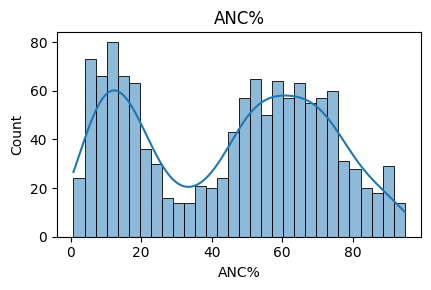

In [5]:
target = 'ANC%'
ML = Features.copy()

label=ML[[target]].copy()
plot_distributions(label)

In [6]:
mean_value = ML[target].mean()
ML[target] = ML[target].apply(lambda x: 1 if x > mean_value else 0)

In [7]:

ML = ML[['Province']+[target] + streetViewParams]
X_train, X_test, y_train, y_test = train_test_split(ML.drop([target], axis=1), ML[target], test_size=0.2, random_state=42)


In [8]:
# Function to find skewed features that need scaling
def find_features_to_scale(df, skew_threshold=0.5):
    # Identify numeric columns
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    # Calculate skewness for each numeric feature
    skewness = df[numeric_features].apply(lambda x: skew(x.dropna()))

    # Select skewed features
    skewed_features = skewness[abs(skewness) > skew_threshold].index.tolist()
    
    return skewed_features, numeric_features

In [9]:
YeoJohnsonTransformer = PowerTransformer(method='yeo-johnson')

YJ_pipeline = Pipeline([
    ("YJ", YeoJohnsonTransformer),
])

Remainder_pipeline = Pipeline([
    ("Standardize", StandardScaler()),
])

Encoder_pipeline = Pipeline([
    ("OneHot", OneHotEncoder(drop='first', dtype=int, handle_unknown='ignore')),
])

YJ_Attributes, all_numeric_features = find_features_to_scale(X_train)


Remainder_Attributes = list(set(all_numeric_features) - set(YJ_Attributes))


Encoder_Attributes = ['Province']

In [10]:
preprocessing = ColumnTransformer([
    ("Scalling", YJ_pipeline, YJ_Attributes),
    ("Standardise", Remainder_pipeline, Remainder_Attributes),
    ("OneHot", Encoder_pipeline, Encoder_Attributes),
])

preprocessing

ColumnTransformer(transformers=[('Scalling',
                                 Pipeline(steps=[('YJ', PowerTransformer())]),
                                 ['NuPhotos', 'PotholeRatio', 'PeopleRatio',
                                  'TrashRatio', 'CarRatio', 'BusRatio',
                                  'TruckRatio', 'MotorbikeRatio',
                                  'PotholeLagDifference', 'PeopleLagDifference',
                                  'TrashLagDifference', 'CarLagDifference',
                                  'BusLagDifference', 'TrucklagDifference',
                                  'MotorbikeLagDifference', 'PeopleCarRatio']),
                                ('Standardise',
                                 Pipeline(steps=[('Standardize',
                                                  StandardScaler())]),
                                 ['RoadRatio', 'RoadLagDifffference']),
                                ('OneHot',
                                 Pipeline(steps=[('OneHot',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore'))]),
                                 ['Province'])])

In [11]:
processedDataTrain = preprocessing.fit_transform(X_train)
processedDataTest = preprocessing.fit_transform(X_test)



In [12]:
# Convert transformed data back to DataFrame
feature_names = (
    YJ_Attributes +
    Remainder_Attributes +
    preprocessing.named_transformers_["OneHot"].get_feature_names_out(Encoder_Attributes).tolist()
)


Temp = pd.DataFrame(processedDataTrain, columns=feature_names)
X_train = Temp

Temp = pd.DataFrame(processedDataTest, columns=feature_names)
X_test = Temp

# Log Regression

## Correlations Functions

In [13]:
def CorrelationCreation(attributes, df, Number, Threshold):
    # Compute Pearson and Spearman correlation matrices
    corr_matrix_pearson = df[attributes].corr(method='pearson')
    corr_matrix_spearman = df[attributes].corr(method='spearman')

    top_pearson_threshold = corr_matrix_pearson[attributes[0]].apply(abs)  # Calculate absolute correlation values
    top_pearson_threshold = top_pearson_threshold[top_pearson_threshold > Threshold].sort_values(ascending=False).index.tolist()  # Filter for correlation > Threshold
    top_pearson_threshold = [feature for feature in top_pearson_threshold if feature != attributes[0]]  # Remove the target column
    corr_matrix_pearson = df[[attributes[0]]+top_pearson_threshold].corr(method='pearson')

    top_spearman_threshold = corr_matrix_spearman[attributes[0]].apply(abs)  # Calculate absolute correlation values
    top_spearman_threshold = top_spearman_threshold[top_spearman_threshold > Threshold].sort_values(ascending=False).index.tolist()  # Filter for correlation > Threshold
    top_spearman_threshold = [feature for feature in top_spearman_threshold if feature != attributes[0]]  # Remove the target column
    corr_matrix_spearman = df[[attributes[0]]+top_spearman_threshold].corr(method='spearman')

    # Print Pearson correlation for the first attribute
    print("\nPearson Correlation")
    print(corr_matrix_pearson[attributes[0]].sort_values(ascending=False))

    # Print Spearman correlation for the first attribute
    print("\nSpearman Correlation")
    print(corr_matrix_spearman[attributes[0]].sort_values(ascending=False))

    # Plotting the top x
    TempNumber = Number
    if(TempNumber > len(top_pearson_threshold)):
        TempNumber = len(top_pearson_threshold)

    top_pearson = corr_matrix_pearson[attributes[0]].apply(abs).sort_values(ascending=False).head(TempNumber).index.tolist()[1:]

    TempNumber = Number
    if(TempNumber > len(top_spearman_threshold)):
        TempNumber = len(top_spearman_threshold)
    top_spearman = corr_matrix_spearman[attributes[0]].apply(abs).sort_values(ascending=False).head(Number).index.tolist()[1:]

    # Get the top 8 features to plot
    corr_matrix_pearson_top = corr_matrix_pearson.loc[top_pearson, top_pearson]
    corr_matrix_spearman_top = corr_matrix_spearman.loc[top_spearman, top_spearman]

    # Set up figure for heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Pearson Correlation Heatmap
    sns.heatmap(corr_matrix_pearson_top, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
    axes[0].set_title("Pearson Correlation Heatmap")

    # Spearman Correlation Heatmap
    sns.heatmap(corr_matrix_spearman_top, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
    axes[1].set_title("Spearman Correlation Heatmap")

    # Tight layout for heatmaps
    plt.tight_layout()
    plt.show()



    return top_pearson, top_spearman, top_pearson_threshold, top_spearman_threshold


In [14]:
def feature_reduction(attributes, df, threshold=0.9):
    # Compute Pearson correlation matrices
    corr_matrix_pearson = df[attributes].corr(method='pearson')
    
    # Get the correlation with the target column
    corr_with_target_pearson = corr_matrix_pearson[attributes[0]].apply(abs)

    # Step 1: Identify multicollinear features (above the threshold)
    features_to_remove = set()
    for i in range(len(attributes)):
        for j in range(i + 1, len(attributes)):  # Only check the upper triangle to avoid redundancy
            if abs(corr_matrix_pearson.iloc[i, j]) > threshold:  # If the correlation is greater than the threshold
                feature_i = attributes[i]
                feature_j = attributes[j]
                
                # Step 2: Keep the feature most correlated with the target
                if corr_with_target_pearson[feature_i] >= corr_with_target_pearson[feature_j]:
                    features_to_remove.add(feature_j)
                else:
                    features_to_remove.add(feature_i)

    # Step 3: Filter out multicollinear features and keep the ones most related to the target
    attributes_cleaned = [feature for feature in attributes if feature not in features_to_remove]

    # Return the remaining features after reduction
    return attributes_cleaned


## Pre Feature Reduction

In [15]:
# Create an instance of the LinearRegression model
log_reg = LogisticRegression()

# Fit the model to the training data
log_reg.fit(X_train, y_train)

LogisticRegression()

In [16]:
# Evaluate the model with cross-validation on the training set
cv_results_train = cross_val_score(log_reg, X_train, y_train, cv=10, scoring='roc_auc')
print(f"Cross-Validation ROC-AUC Scores (Train Set): {cv_results_train}")
print(f"Average ROC-AUC (Train Set): {cv_results_train.mean()}")

Cross-Validation ROC-AUC Scores (Train Set): [0.97527911 0.97886762 0.9900319  0.97368421 0.97208931 0.9437799
 0.94926948 0.9338474  0.97266422 0.95267238]
Average ROC-AUC (Train Set): 0.9642185537840373


In [17]:
# Evaluate the model with cross-validation on the training set
cv_results_train = cross_val_score(log_reg, X_test, y_test, cv=10, scoring='roc_auc')
print(f"Cross-Validation ROC-AUC Scores (Train Set): {cv_results_train}")
print(f"Average ROC-AUC (Train Set): {cv_results_train.mean()}")

Cross-Validation ROC-AUC Scores (Train Set): [0.93939394 0.89090909 0.94805195 0.95454545 0.94155844 0.9025974
 0.97402597 0.98701299 1.         0.97333333]
Average ROC-AUC (Train Set): 0.9511428571428571


In [18]:
y_pred = log_reg.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')  # Use 'macro' for multiclass
recall = recall_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Accuracy: 0.92
Precision: 0.92, Recall: 0.92, F1 Score: 0.92


In [19]:
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'macro' for multiclass
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Accuracy: 0.91
Precision: 0.91, Recall: 0.91, F1 Score: 0.91


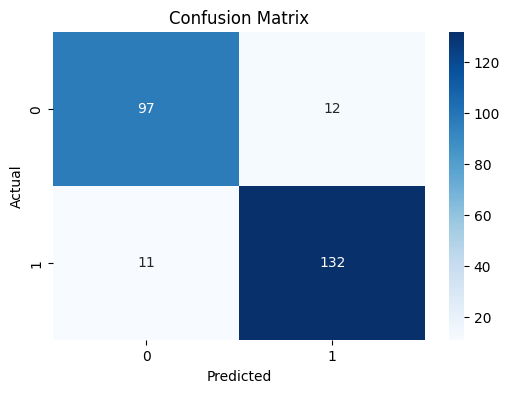

In [20]:
class_names = log_reg.classes_  # Automatically gets class labels


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Notes


LogisticRegression Works the Best

# Getting the most important features and displaying exploring those 

In [21]:
def CreateRadarChart(attributes, df):
    # The first attribute in the list will be used as the label
    label = attributes[0]

    # Compute Pearson and Spearman correlation matrices
    corr_matrix_pearson = df[attributes].corr(method='pearson')
    corr_matrix_spearman = df[attributes].corr(method='spearman')

    # Get the top 6 correlation values based on absolute values for the specified label (first attribute in the list)
    pearson_values = corr_matrix_pearson[label].apply(abs).sort_values(ascending=False).head(7).values[1:]  # Excluding the label itself
    spearman_values = corr_matrix_spearman[label].apply(abs).sort_values(ascending=False).head(7).values[1:]

    # Labels for the radar chart (sorted based on absolute Pearson correlation)
    labels = corr_matrix_pearson[label].apply(abs).sort_values(ascending=False).head(7).index.tolist()[1:]  # Excluding the label itself

    # Make the radar chart 'close to a circle'
    pearson_values = np.concatenate((pearson_values, [pearson_values[0]]))
    spearman_values = np.concatenate((spearman_values, [spearman_values[0]]))
    
    # Number of variables (Top 6 features)
    num_vars = len(labels)

    # Compute angle for each axis of the radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Add the first angle to make the chart 'close to a circle' 
    angles += angles[:1]

    # Set up the figure
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100, subplot_kw=dict(polar=True))

    # Plot data
    ax.plot(angles, pearson_values, color='blue', linewidth=2, label='Pearson Correlation (Abs)')
    ax.fill(angles, pearson_values, color='blue', alpha=0.25)

    ax.plot(angles, spearman_values, color='red', linewidth=2, label='Spearman Correlation (Abs)')
    ax.fill(angles, spearman_values, color='red', alpha=0.25)

    # Labels and title
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, rotation=45, ha='right')

    plt.title(f"Top 6 Absolute Correlations for {label}: Pearson vs. Spearman", size=16)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.show()


In [22]:
def CorrelationCreation(attributes, df):
    # Compute Pearson and Spearman correlation matrices
    corr_matrix_pearson = df[attributes].corr(method='pearson')
    corr_matrix_spearman = df[attributes].corr(method='spearman')

    # Print Pearson correlation for the first attribute
    print("\nPearson Correlation")
    print(corr_matrix_pearson[attributes[0]].sort_values(ascending=False))

    # Print Spearman correlation for the first attribute
    print("\nSpearman Correlation")
    print(corr_matrix_spearman[attributes[0]].sort_values(ascending=False))

    # Get the top 6 features with the highest absolute correlation for both Pearson and Spearman
    top_pearson = corr_matrix_pearson[attributes[0]].apply(abs).sort_values(ascending=False).head(7).index.tolist()[1:]
    top_spearman = corr_matrix_spearman[attributes[0]].apply(abs).sort_values(ascending=False).head(7).index.tolist()[1:]

    # Get the top 8 features to plot
    corr_matrix_pearson_top = corr_matrix_pearson.loc[top_pearson, top_pearson]
    corr_matrix_spearman_top = corr_matrix_spearman.loc[top_spearman, top_spearman]

    # Set up figure for heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Pearson Correlation Heatmap
    sns.heatmap(corr_matrix_pearson_top, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
    axes[0].set_title("Pearson Correlation Heatmap")

    # Spearman Correlation Heatmap
    sns.heatmap(corr_matrix_spearman_top, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
    axes[1].set_title("Spearman Correlation Heatmap")

    # Tight layout for heatmaps
    plt.tight_layout()
    plt.show()



    return top_pearson, top_spearman


In [23]:
def CreateScatterPlot(df,attributes):
    scatter_matrix(df[attributes], figsize=(20, 14))
    plt.show()
    return

## All Features


Pearson Correlation
Non Vote Percentage (Registered)    1.000000
PotholeRatio                        0.252359
PotholeLagDifference                0.170727
PeopleCarRatio                      0.134960
MotorbikeRatio                      0.103207
PeopleRatio                         0.099201
TruckRatio                          0.086191
CarLagDifference                    0.074312
BusRatio                            0.067807
TrucklagDifference                  0.054009
MotorbikeLagDifference              0.036813
CarRatio                            0.034264
TrashLagDifference                  0.033162
BusLagDifference                    0.031966
TrashRatio                          0.024665
PeopleLagDifference                -0.000975
RoadLagDifffference                -0.080946
RoadRatio                          -0.350499
NuPhotos                           -0.522065
Name: Non Vote Percentage (Registered), dtype: float64

Spearman Correlation
Non Vote Percentage (Registered)    1.000000
Pe

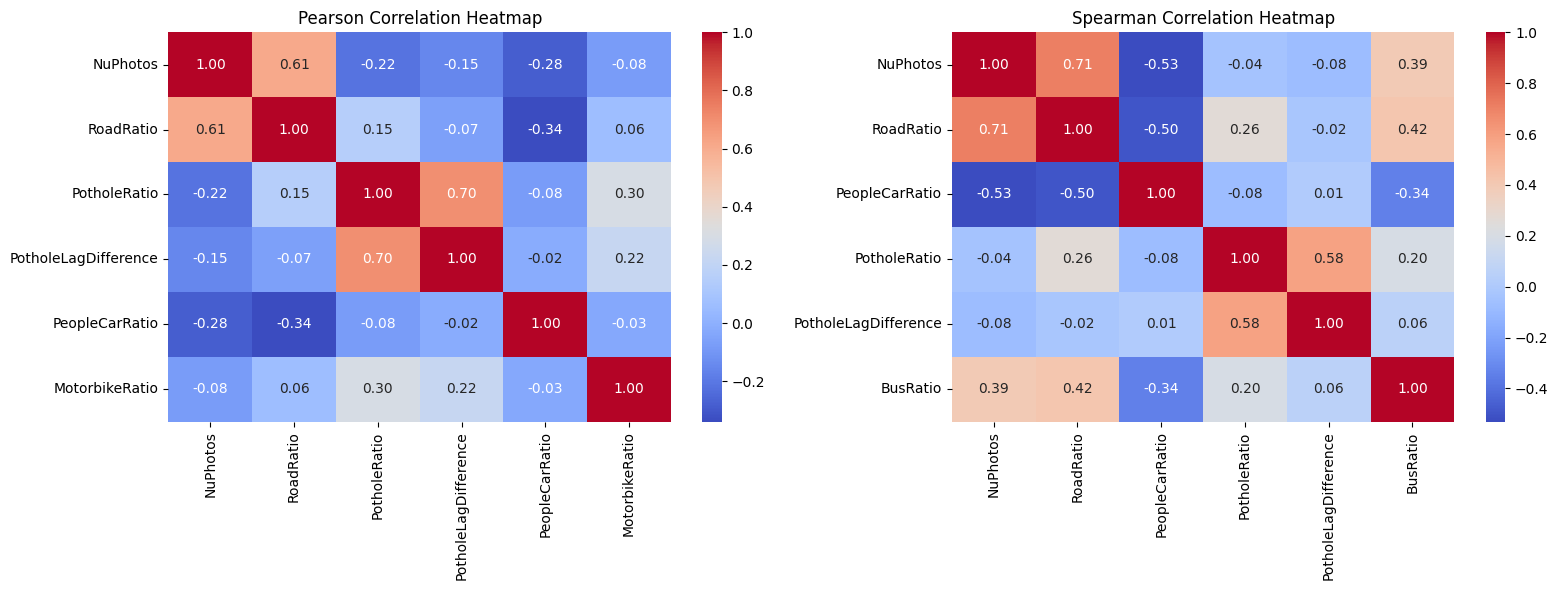

In [24]:
attributes = ['Non Vote Percentage (Registered)'] + streetViewParams
toppearson, topspearmam = CorrelationCreation(attributes, Features)

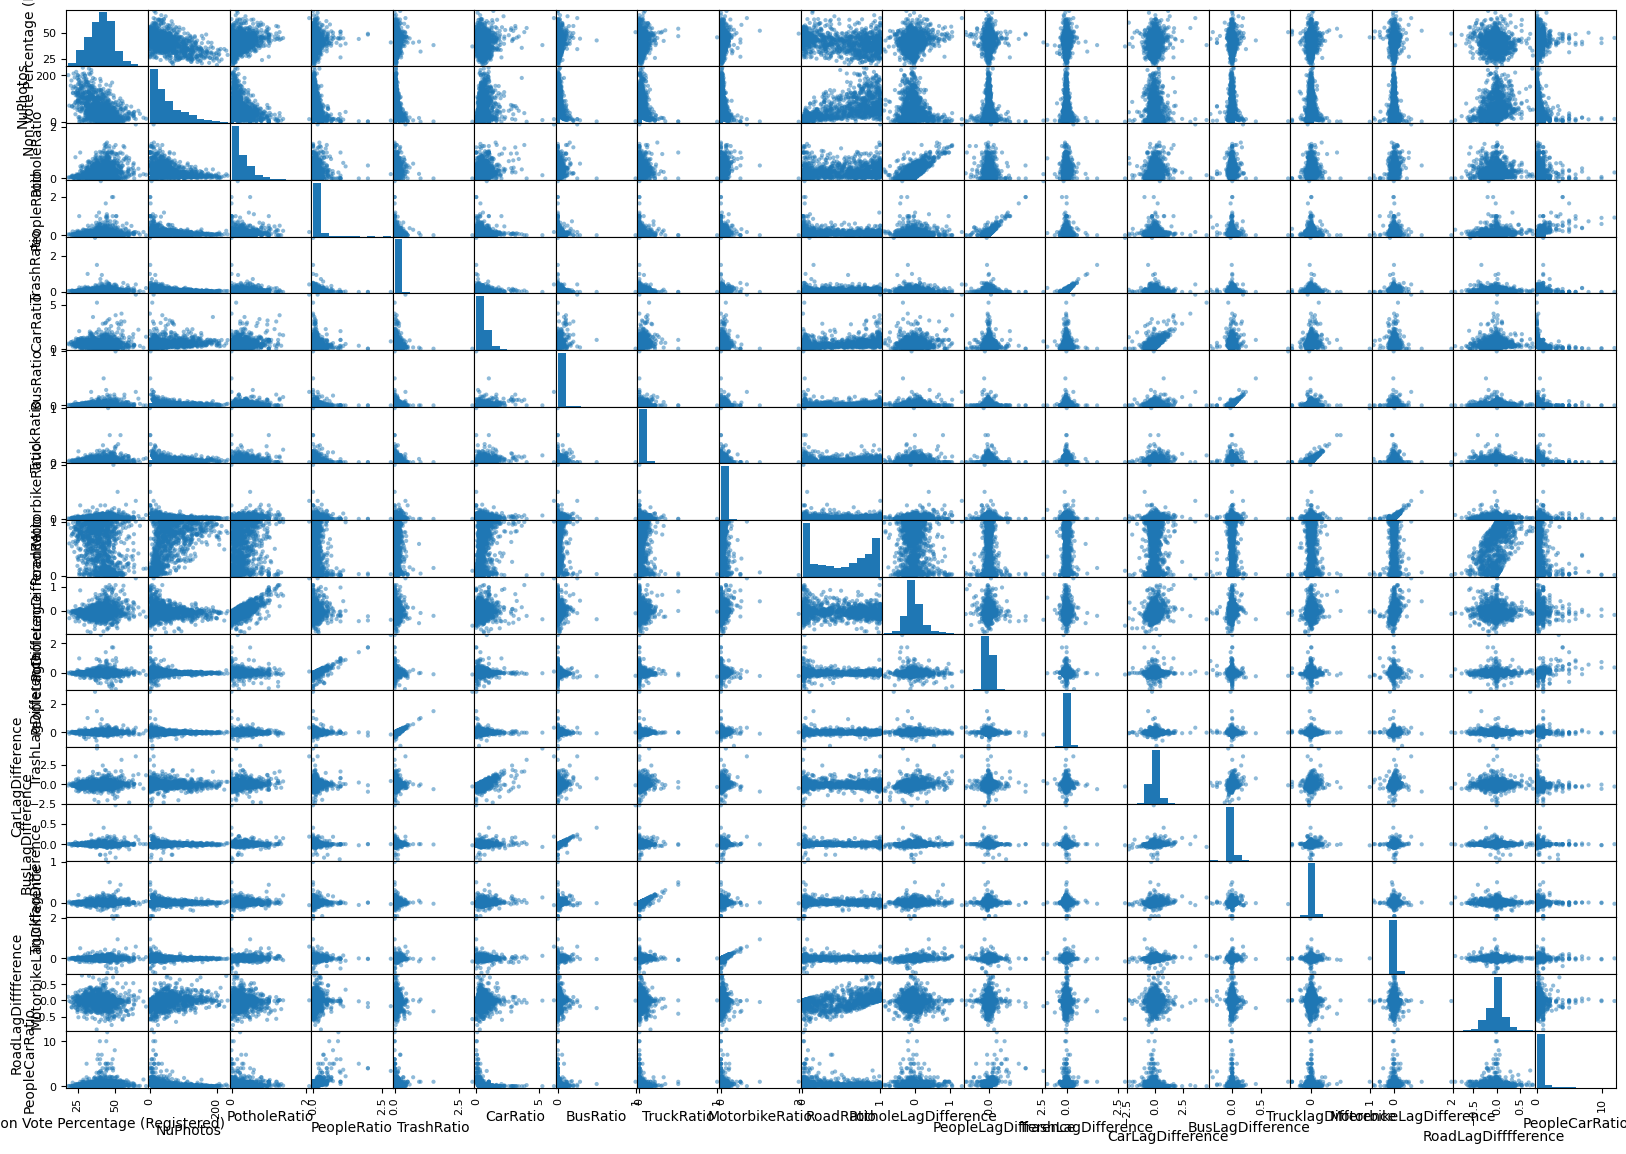

In [25]:
CreateScatterPlot(Features,attributes)

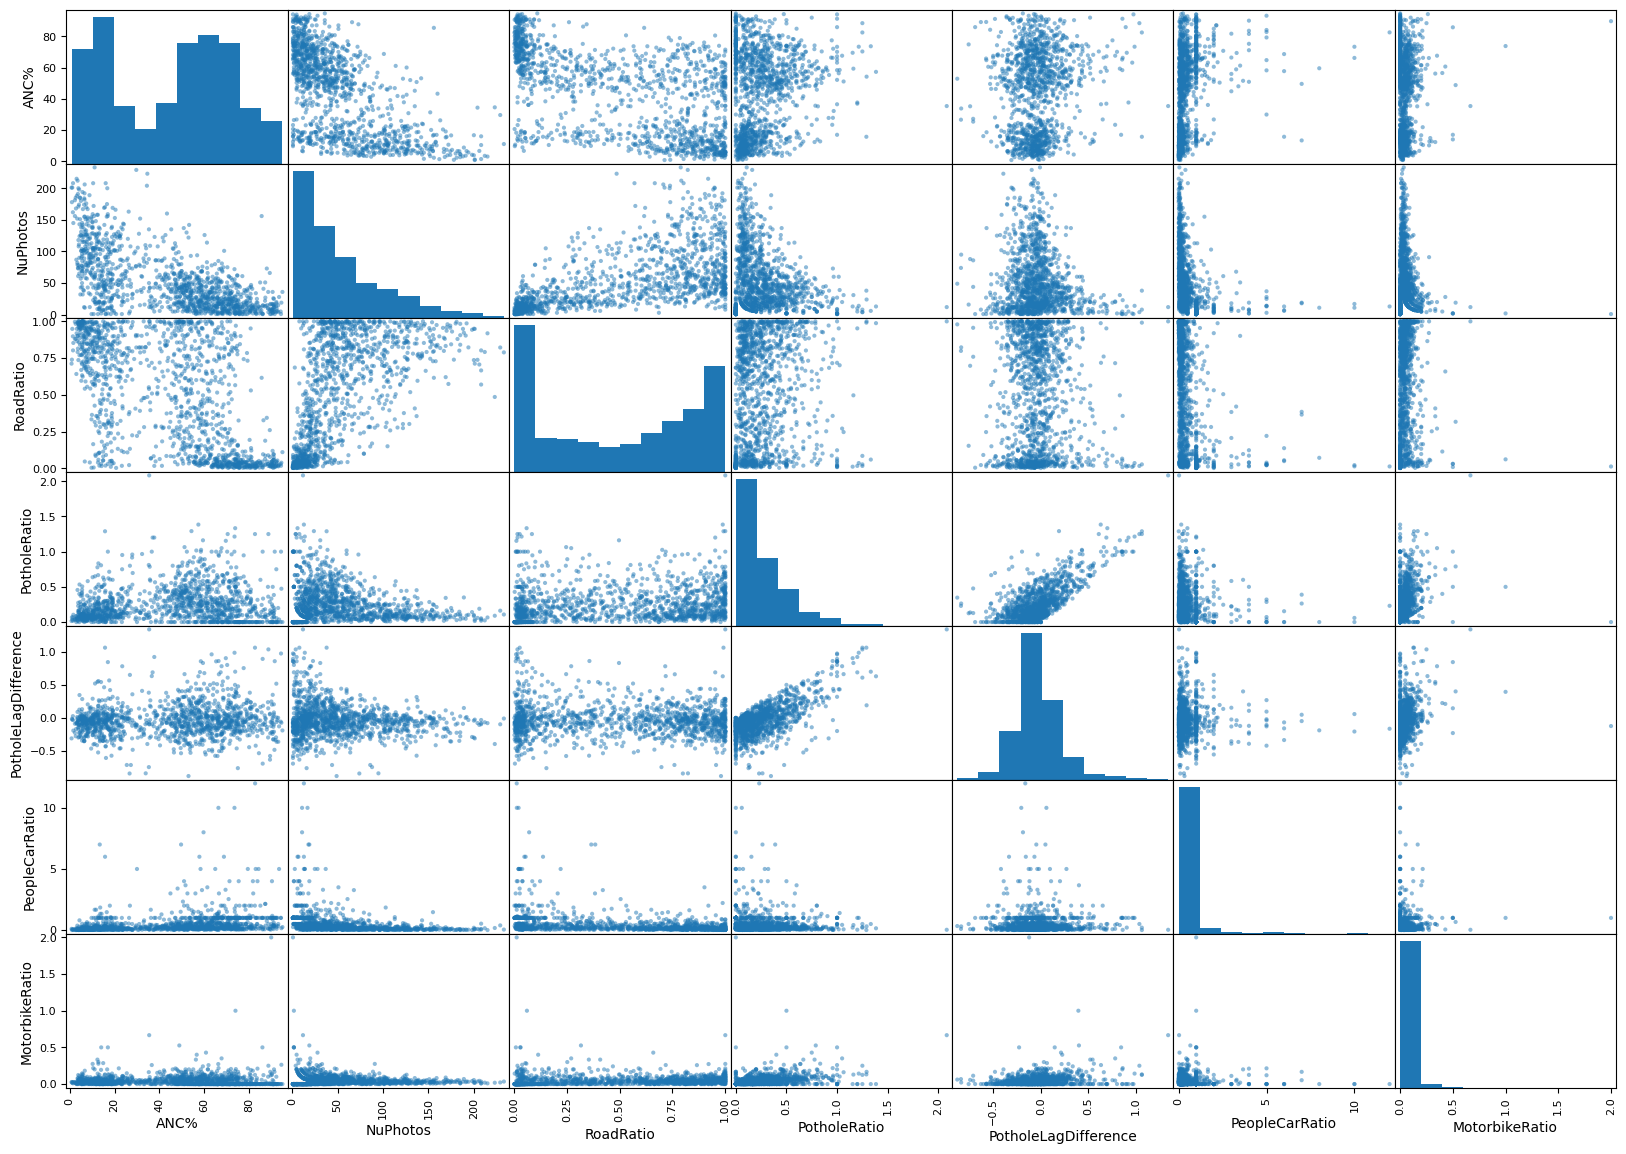

In [26]:
CreateScatterPlot(Features,[target] + toppearson)

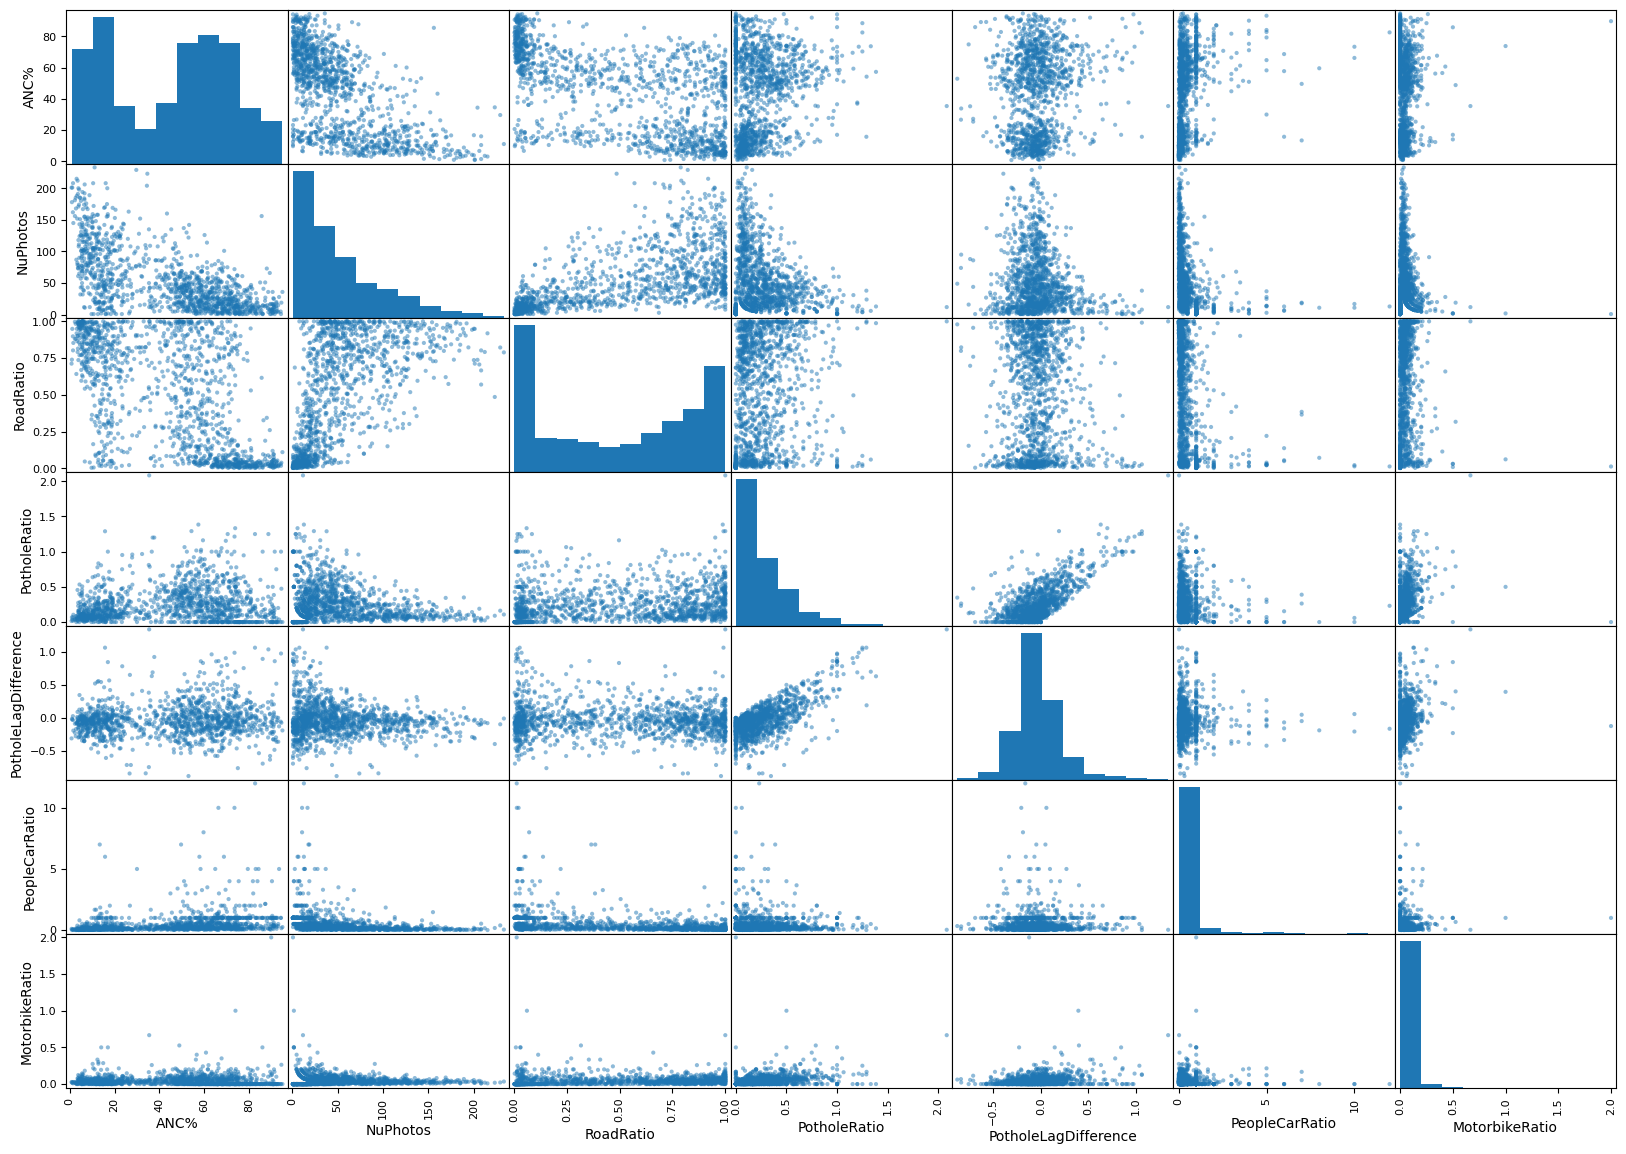

In [27]:
CreateScatterPlot(Features,[target] + toppearson)

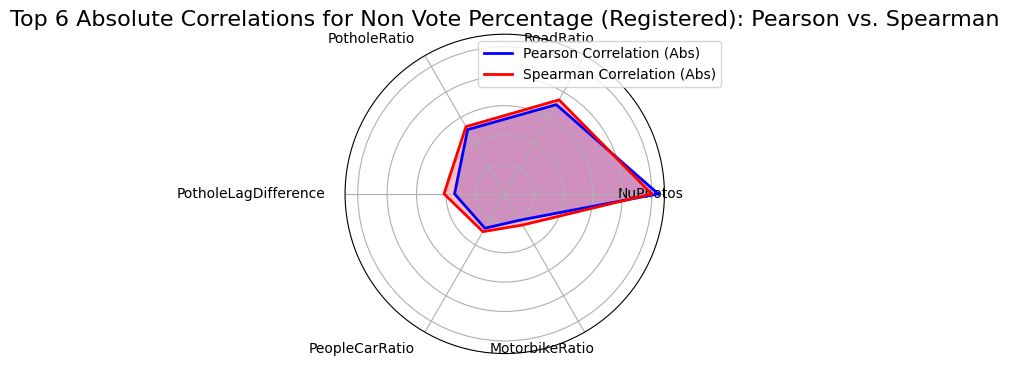

In [28]:
CreateRadarChart(attributes, Features)

## Important Features